In [105]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

First, select only protein and/or ligand from trajectory to create a new reduced trajectory and compatible topology:


```bash
$ cd zeb_hb_only_sim
$ gmx trjconv -s sys_prod/prod_zeb_hb_only.tpr -f sys_prod/prod_zeb_hb_only_compact_compact.xtc -o sys_prod/prod_zeb_hb_only_compact_compact_compact.xtc              
$ gmx convert-tpr -s sys_prod/prod_zeb_hb_only.tpr  -o sys_prod/prod_zeb_hb_only_compact_compact_compact.tpr
```

Select only Protein

```bash

$ cd ../zeb_hb_phz_complex_sim/ 
$ gmx trjconv -s sys_prod/prod_zeb_hb_phz_complex.tpr -f sys_prod/prod_zeb_hb_phz_complex_compact_compact.xtc -o sys_prod/prod_zeb_hb_phz_complex_compact_compact_compact.xtc  -n zeb_hb_phz_complex_water_ion_index.ndx
$ gmx convert-tpr -s sys_prod/prod_zeb_hb_phz_complex.tpr -n zeb_hb_phz_complex_water_ion_index.ndx -o sys_prod/prod_zeb_hb_phz_complex_compact_compact_compact.tpr
```

Select 'PHZ_Protein'

## RMSD of Zebrafish Hb only

In [3]:
from MDAnalysis.analysis import rms
#Read all the trajectories
protein_prod = mda.Universe('zeb_hb_only_sim/sys_prod/prod_zeb_hb_only_compact_compact_compact.tpr', 'zeb_hb_only_sim/sys_prod/prod_zeb_hb_only_compact_compact_compact.xtc')

In [5]:
RMSD_zebhb = rms.RMSD(protein_prod,  # universe to align
    protein_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

RMSD_zebhb.run(verbose=True)
times_p = RMSD_zebhb.results.rmsd[:,1]
rmsd_p = RMSD_zebhb.results.rmsd[:,2]

  0%|          | 0/20001 [00:00<?, ?it/s]

## Radius of Gyration of Zebrafish Hb only

In [6]:
from tqdm.notebook import tqdm
group = protein_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(protein_prod.trajectory):
	Frame.append(ts.frame)
	times.append(protein_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrp_table = np.vstack((Frame, times, Rgyr)).T

  0%|          | 0/20001 [00:00<?, ?it/s]

## RMSD of Zebrafish Hb and PHZ Complex

In [7]:
from MDAnalysis.analysis import rms
#Read all the trajectories
complex_prod = mda.Universe('zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact_compact.tpr', 'zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact_compact.xtc')

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/coordinates/XDR.py:253: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn(


In [8]:
RMSD_complex = rms.RMSD(complex_prod,  # universe to align
    complex_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

RMSD_complex.run(verbose=True)
times_c = RMSD_complex.results.rmsd[:,1]
rmsd_c = RMSD_complex.results.rmsd[:,2]

  0%|          | 0/20001 [00:00<?, ?it/s]

## Radius of Gyration of Zebrafish Hb and PHZ Complex

In [9]:
from tqdm.notebook import tqdm
group = complex_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(complex_prod.trajectory):
	Frame.append(ts.frame)
	times.append(complex_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T

  0%|          | 0/20001 [00:00<?, ?it/s]

## RMSF: Protein backbone and Carbon alpha

In [10]:
c_alphas_p = protein_prod.select_atoms('backbone and name CA')
R_p = rms.RMSF(c_alphas_p).run(verbose=True)

c_alphas_c = complex_prod.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)

  0%|          | 0/20001 [00:00<?, ?it/s]

  0%|          | 0/20001 [00:00<?, ?it/s]

## H-bond analysis:

Note: as of today (20240929), the latest stable version of `mdanalysis-2.7.0` cannot import `GROMACS` tpr files from `gromacs-2024.2`, yielding this exception

```python
ValueError: Failed to construct topology from file zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.tpr with parser <class 'MDAnalysis.topology.TPRParser.TPRParser'>.
Error: Your tpx version is 133, which this parser does not support, yet
```

So we have to install the development version from GitHub. 

### Instructions:

```bash
$ conda create -n mdanalysis-develop numpy cython ipykernel ipywidgets
$ conda activate mdanalysis-develop
$ git clone --depth=50 https://github.com/MDAnalysis/mdanalysis.git
$ cd mdanalysis
$ git branch

* develop

$ pip install package/
$ pip install testsuite/ #Optional
$ python -c 'import MDAnalysis as mda; print(mda.__version__)'
2.8.0-dev0
```
Then, reload jupyter kernel in this new environment.

Background: [MDAnalysis example: Hydrogen Bonds](https://userguide.mdanalysis.org/stable/examples/analysis/hydrogen_bonds/hbonds.html)

In [106]:
#Giving full tpr file to include bonding info
u = mda.Universe("zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact_compact.tpr",\
            "zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact_compact.xtc")
phz = u.select_atoms('resname PHZ')
protein = u.select_atoms('protein')
num_residues = len(protein.residues)

In [107]:
mda.__version__  # check the version of MDAnalysis

'2.9.0-dev0'

Note that we're selecting PHZ and protein, so the selections need not be updated with each frame. Setting `update_selections=False` drastically speeds up the hbonds run.

**Note** The selections need to be super precise and atom specific, otherwise there will be many false positives during the hydrogen bond detection, as it will try to 'detect' hydrogen bonds for every atom in the selection, even ones that aren't electronegative enough to be donors and/or acceptors. So selections for donors and acceptors should be obtained with the `guess_` methods.

In [129]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

hbonds_phz_prot = HBA(universe=u,
        update_selections=True
        )

hbonds_phz_prot.donors_sel = hbonds_phz_prot.guess_donors("resname PHZ")
hbonds_phz_prot.hydrogens_sel = hbonds_phz_prot.guess_hydrogens("resname PHZ")
hbonds_phz_prot.acceptors_sel = hbonds_phz_prot.guess_acceptors("protein")

hbonds_phz_prot.run(verbose=True)

  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, (resname PHZ and name N2), and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ARG and name OC1) or (resname ARG and name OC2) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HID and name NE2) or (resname HID and name O) or (resname HIE and name ND1) or (resname HIE and name O) or (resname ILE and name O

In [133]:
hbonds_phz_prot.count_by_type()

array([['PHZ:n8', 'ASN:O', '138'],
       ['PHZ:n8', 'HID:NB', '446'],
       ['PHZ:n8', 'ILE:O', '1'],
       ['PHZ:n8', 'LEU:O', '351'],
       ['PHZ:n8', 'PHE:O', '1'],
       ['PHZ:n8', 'THR:O', '1'],
       ['PHZ:n8', 'TYR:O', '10'],
       ['PHZ:n8', 'VAL:O', '2']], dtype='<U21')

The average number of each type of hydrogen bond formed at each frame is likely more informative than the total number over the trajectory. This can be calculated for each hydrogen bond type as follows:

In [134]:
sorted_output = sorted(hbonds_phz_prot.count_by_type(), key=lambda x: float(x[2]), reverse=True)
for donor, acceptor, count in sorted_output:
    donor_resname, donor_type = donor.split(":")
    n_donors = u.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms
    mean_count = 2 * int(count) / (hbonds_phz_prot.n_frames * n_donors)
    print(f"{donor} to {acceptor}: {mean_count:.3f}")

PHZ:n8 to HID:NB: 0.045
PHZ:n8 to LEU:O: 0.035
PHZ:n8 to ASN:O: 0.014
PHZ:n8 to TYR:O: 0.001
PHZ:n8 to VAL:O: 0.000
PHZ:n8 to ILE:O: 0.000
PHZ:n8 to PHE:O: 0.000
PHZ:n8 to THR:O: 0.000


In [135]:
from tqdm import tqdm
from collections import Counter

acceptors = []

for hbond in tqdm(hbonds_phz_prot.results.hbonds):
    frame, donor_ix, hydrogen_ix, acceptor_ix = hbond[:4].astype(int)
    u.trajectory[frame]
    atoms = u.atoms[[donor_ix, hydrogen_ix, acceptor_ix]]
    acceptors.append(f'{str(u.atoms[acceptor_ix].resid)}-{u.atoms[acceptor_ix].resname}')
    
print("The acceptors that participate in h-bonding vs number of frames are:\n")

acceptors_dict = dict(Counter(acceptors))
acceptors_dict

100%|██████████| 950/950 [00:00<00:00, 1174.41it/s]

The acceptors that participate in h-bonding vs number of frames are:



{'60-HID': 98,
 '43-TYR': 10,
 '63-THR': 1,
 '64-ILE': 1,
 '93-LEU': 121,
 '89-HID': 348,
 '88-LEU': 230,
 '95-VAL': 2,
 '99-ASN': 138,
 '91-PHE': 1}

### H-bond parameters
  - *d_h_cutoff* (Å) [1.2] : Distance cutoff used for finding donor-hydrogen pairs
  - *d_a_cutoff* (Å) [3.0] : Distance cutoff for hydrogen bonds. This cutoff refers to the D-A distance.
  - *d_h_a_angle_cutoff* (degrees) [150] : D-H-A angle cutoff for hydrogen bonds.

### Nothing to see if we reverse donor and acceptor

## Plot everything

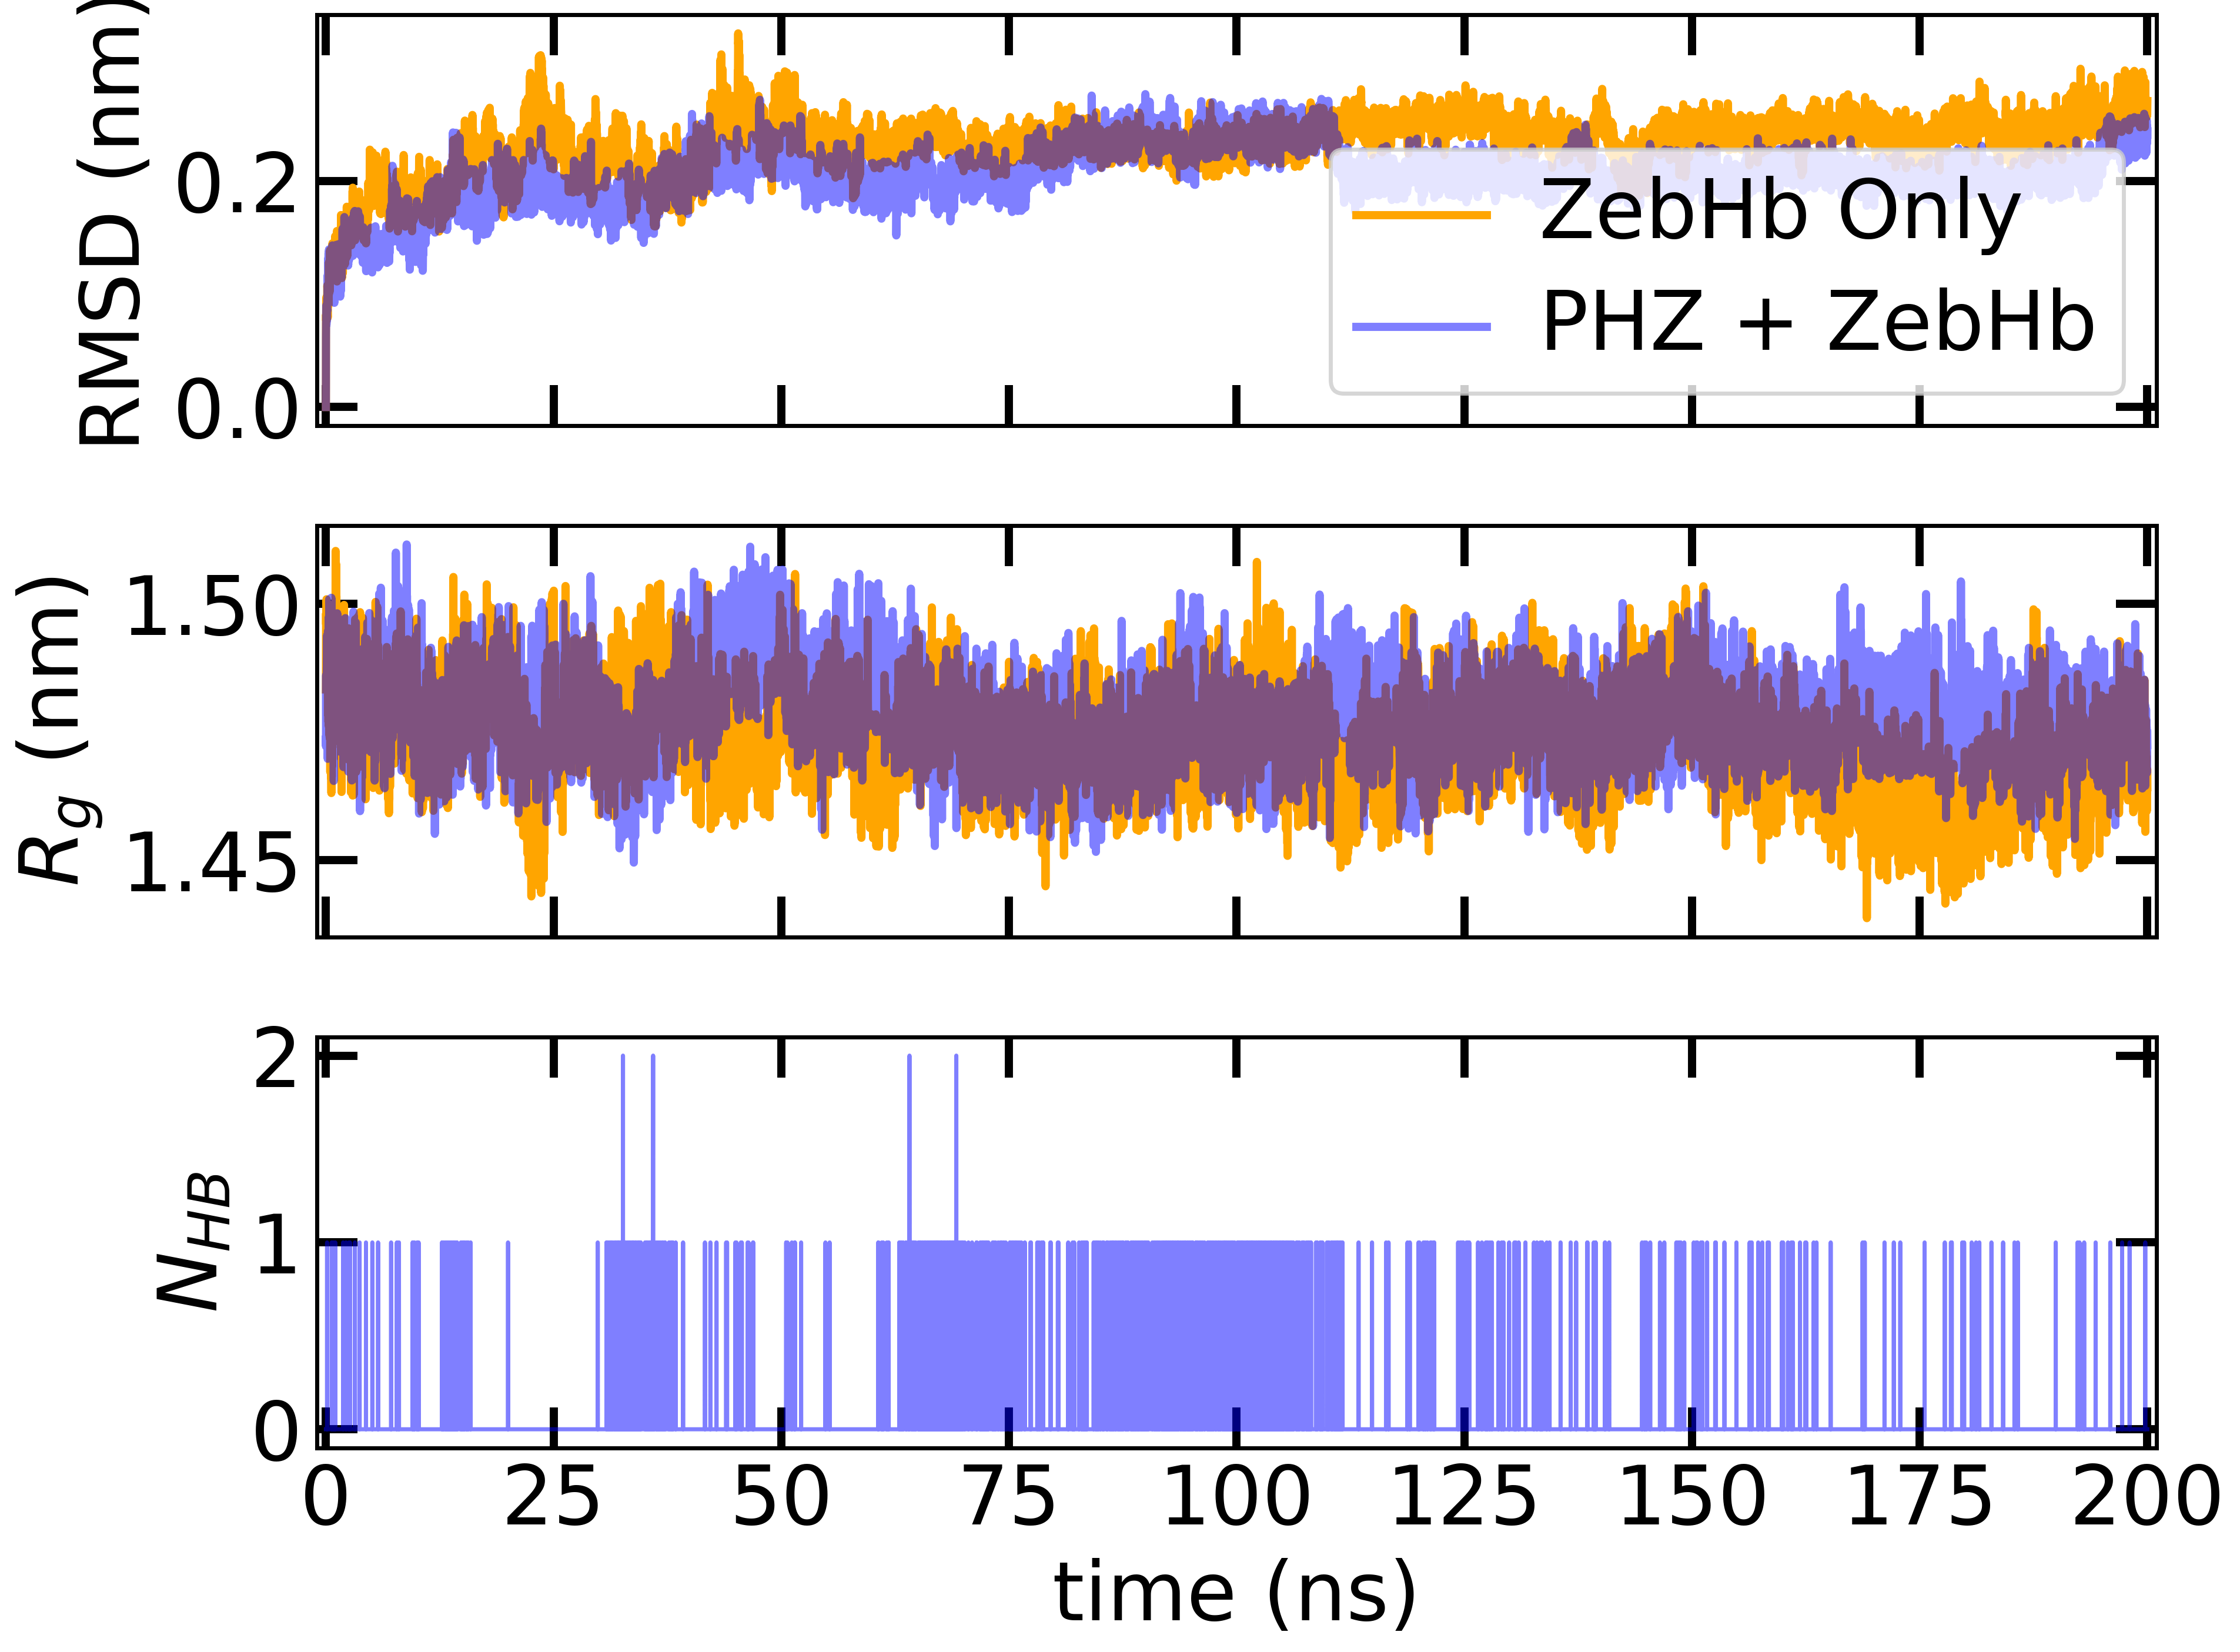

In [136]:
plt.style.use(['science','notebook'])
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True)

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');

ax_rmsd.plot(times_p/1000, rmsd_p/10, label="ZebHb Only", 
            color='orange')
ax_rmsd.plot(times_c/1000, rmsd_c/10, label="PHZ + ZebHb", 
            alpha=0.5, color='blue')

ax_rmsd.legend(loc='lower right', frameon=True)

ax_rg = axs[1]
ax_rg.plot(Rgyrp_table[:,1]/1000, Rgyrp_table[:,2]/10, 
        label="ZebHb Only", color='orange')
ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="PHZ + ZebHb", alpha=0.5,color='blue')
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');
ax_bonds.set_xlim(-1, 201);

ax_bonds.plot(hbonds_phz_prot.times/1000, hbonds_phz_prot.count_by_time(), 
            lw=1, label="PHZ + ZebHb", alpha=0.5,color='blue')

#plt.title("Number of hydrogon bonds over time", weight="bold")
ax_bonds.set_ylabel(r"$N_{HB}$")
# Increase font sizes and tick widths by 25%
for ax in axs:
        # Increase axis label sizes
        ax.xaxis.label.set_size(ax.xaxis.label.get_size() * 1.25)
        ax.yaxis.label.set_size(ax.yaxis.label.get_size() * 1.25)
        
        # Increase tick label sizes
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
                tick.set_fontsize(tick.get_fontsize() * 1.25)
                
        # Increase tick widths for major and minor ticks
        ax.tick_params(axis='both', which='major', width=2.0, length=10.0)
        ax.minorticks_off()
        
        # Increase legend font size if legend exists
        legend = ax.get_legend()
        if legend is not None:
                for text in legend.get_texts():
                        text.set_fontsize(text.get_fontsize() * 1.25)

# Save the figure
plt.savefig("time-series-plots.svg", dpi=600)
plt.show()


/tmp/ipykernel_1445924/3679505515.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


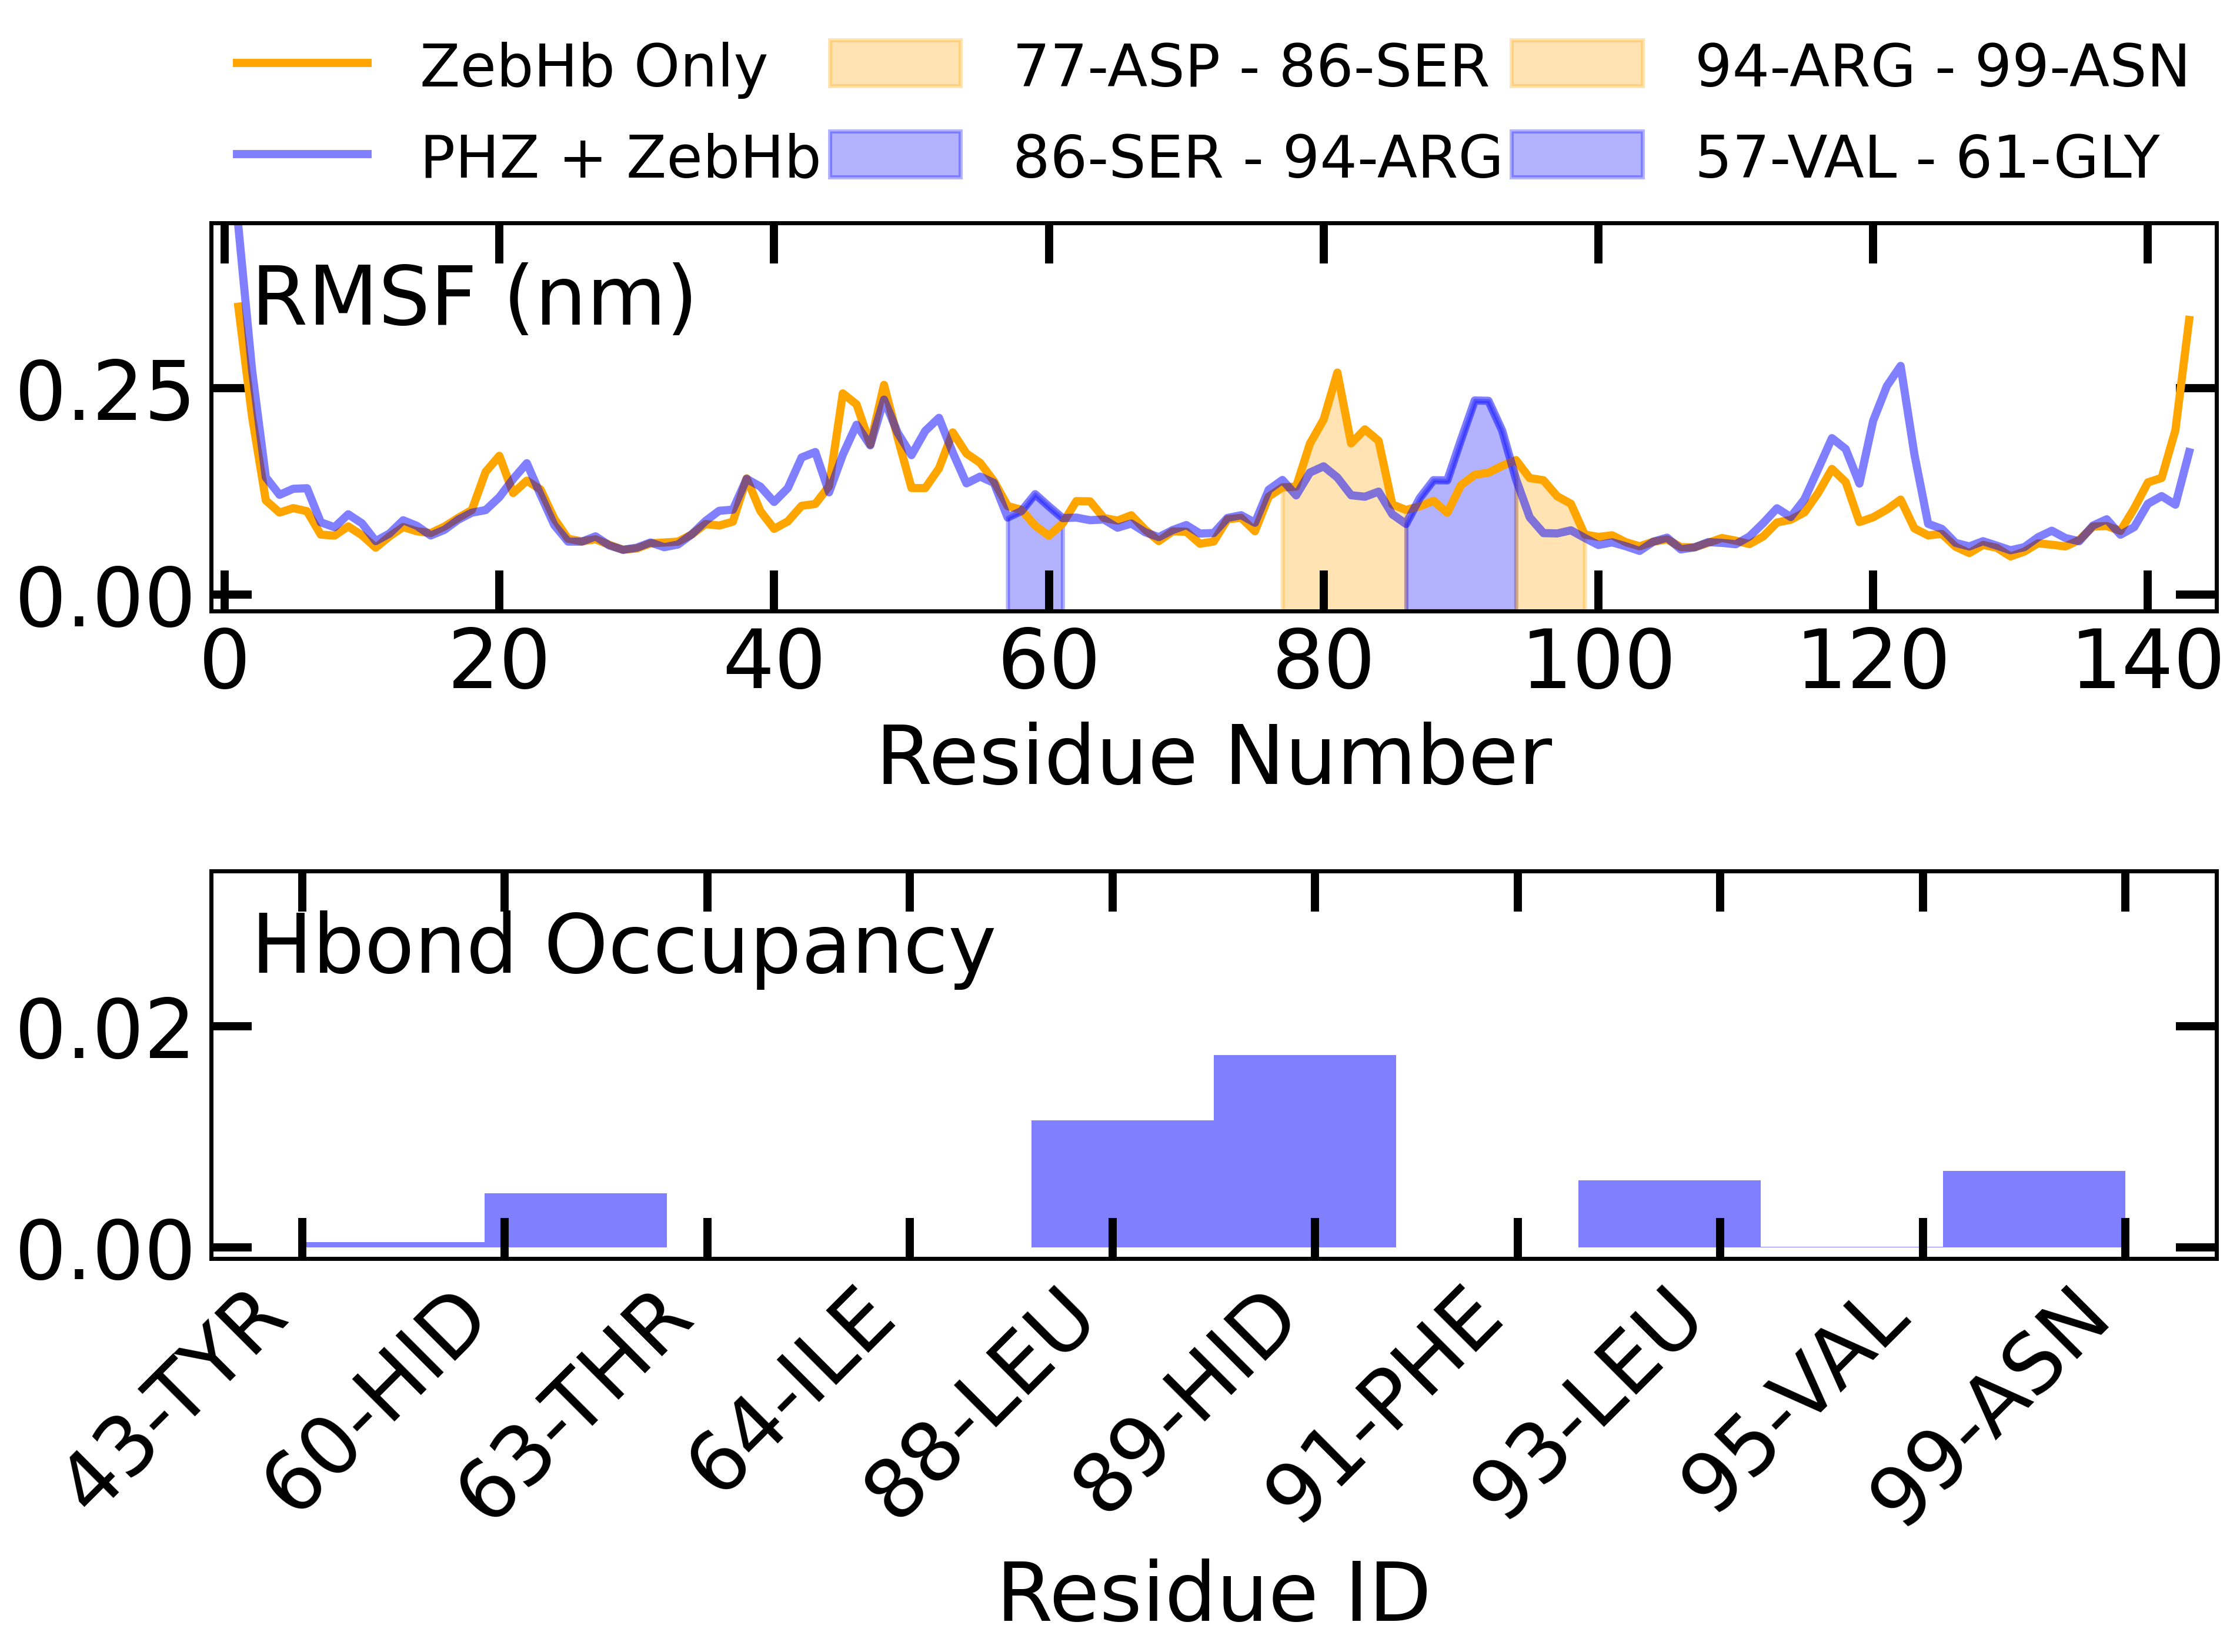

In [144]:
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])
npanels = 3
fig, (ax1, ax2) = plt.subplots(2, 1)

line_p, = ax1.plot(c_alphas_p.resids, R_p.results.rmsf/10, label="ZebHb Only", 
                color="orange")
line_c, = ax1.plot(c_alphas_c.resids, R_c.results.rmsf/10, label="PHZ + ZebHb", 
                alpha=0.5, color="blue")

def fill_resids(ax, resids, rmsf, label, color):
    first_resid, last_resid = resids[0], resids[-1]
    first_residue = protein_prod.select_atoms(f'resid {first_resid}')
    last_residue = protein_prod.select_atoms(f'resid {last_resid}')


    resnames = f'{first_resid}-{first_residue.resnames[0]} - {last_resid}-{last_residue.resnames[0]}' 
        
    ax.fill_between(resids, -0.02, rmsf[resids-1]/10, alpha=0.3, label=resnames,color=color)

fill_resids(ax1, np.arange(77, 87), R_p.results.rmsf, "ZebHb Only",line_p.get_color())
fill_resids(ax1, np.arange(86, 95), R_c.results.rmsf, "PHZ + ZebHb",line_c.get_color())
fill_resids(ax1, np.arange(94, 100), R_p.results.rmsf, "ZebHb Only",line_p.get_color())
fill_resids(ax1, np.arange(57, 62), R_c.results.rmsf, "PHZ + ZebHb",line_c.get_color())

ax1.set_xlabel('Residue Number')
ax1.text(0.02, 0.9, 'RMSF (nm)', transform=ax1.transAxes,
    fontsize=20, verticalalignment='top', horizontalalignment='left')
ax1.set_xlim(-1, 145)
ax1.set_ylim(-0.02, 0.45)
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=3, mode="expand", borderaxespad=0.)

sorted_acceptors = sorted(acceptors, key=lambda x: int(x.split('-')[0]))

ax2.hist(sorted_acceptors, bins=len(set(sorted_acceptors)),
        weights=np.ones(len(sorted_acceptors))/hbonds_phz_prot.n_frames, color= "blue", alpha=0.5, align='mid')

ax2.set_xlabel('Residue ID')
ax2.text(0.02, 0.9, 'Hbond Occupancy', transform=ax2.transAxes,
    fontsize=20, verticalalignment='top', horizontalalignment='left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylim(-0.001, 0.034)


# Increase font sizes and tick widths by 25%
for ax in (ax1, ax2):
        # Increase axis label sizes
        ax.xaxis.label.set_size(ax.xaxis.label.get_size() * 1.25)
        ax.yaxis.label.set_size(ax.yaxis.label.get_size() * 1.25)
        
        # Increase tick label sizes
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
                tick.set_fontsize(tick.get_fontsize() * 1.25)
                
        # Increase tick widths for major and minor ticks
        ax.tick_params(axis='both', which='major', width=2.0, length=10.0)
        ax.minorticks_off()
        # Increase legend font size if legend exists
        legend = ax.get_legend()
        if legend is not None:
                for text in legend.get_texts():
                        text.set_fontsize(text.get_fontsize() * 0.9)
# Save the figure
plt.savefig("rmsf-hbonds.svg", dpi=600)
plt.tight_layout()

## Refined H-bond analysis

Take the top five residues from the histogram above and rerun hbonds with each uniquely selected, the hbonds donor and acceptor atoms keep changing.

In [145]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

resnums = [60, 88, 89, 93, 99]
npanels = len(resnums)
hbonds_top5 = []

for rn in resnums:
        hb = HBA(universe=u, update_selections=True)
        hb.donors_sel = hb.guess_donors("resname PHZ")
        hb.hydrogens_sel = hb.guess_hydrogens("resname PHZ")
        hb.acceptors_sel = "resnum "+str(rn)+" and ("
        hb.acceptors_sel += hb.guess_acceptors("resnum "+str(rn)) + ")"
        print(hb.acceptors_sel)
        hb.run(verbose=True)

        # Filter the hydrogen bonds to keep only those where the donor atom belongs to PHZ
        filtered_hbonds = []
        for hbond in hb.results.hbonds:
            donor_idx = int(hbond[1])  # donor atom index
            if u.atoms[donor_idx].resname == "PHZ":
                filtered_hbonds.append(hbond)
        hb.results.hbonds = np.array(filtered_hbonds)
        hbonds_top5.append(hb)

resnum 60 and ((resname HID and name NE2) or (resname HID and name O))


  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, (resname PHZ and name N2), and Acceptor, resnum 60 and ((resname HID and name NE2) or (resname HID and name O)).
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname PHZ and name N2), and Acceptor, resnum 60 and ((resname HID and name NE2) or (resname HID and name O)).
  warnings.warn(


resnum 88 and ((resname LEU and name O))


  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, (resname PHZ and name N2), and Acceptor, resnum 88 and ((resname LEU and name O)).
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname PHZ and name N2), and Acceptor, resnum 88 and ((resname LEU and name O)).
  warnings.warn(


resnum 89 and ((resname HID and name NE2) or (resname HID and name O))


  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, (resname PHZ and name N2), and Acceptor, resnum 89 and ((resname HID and name NE2) or (resname HID and name O)).
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname PHZ and name N2), and Acceptor, resnum 89 and ((resname HID and name NE2) or (resname HID and name O)).
  warnings.warn(


resnum 93 and ((resname LEU and name O))


  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, (resname PHZ and name N2), and Acceptor, resnum 93 and ((resname LEU and name O)).
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname PHZ and name N2), and Acceptor, resnum 93 and ((resname LEU and name O)).
  warnings.warn(


resnum 99 and ((resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1))


  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, (resname PHZ and name N2), and Acceptor, resnum 99 and ((resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1)).
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname PHZ and name N2), and Acceptor, resnum 99 and ((resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1)).
  warnings.warn(


/tmp/ipykernel_1445924/3928374429.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right', fontsize='x-small')
/tmp/ipykernel_1445924/3928374429.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right', fontsize='x-small')
/tmp/ipykernel_1445924/3928374429.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right', fontsize='x-small')
/tmp/ipykernel_1445924/3928374429.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_

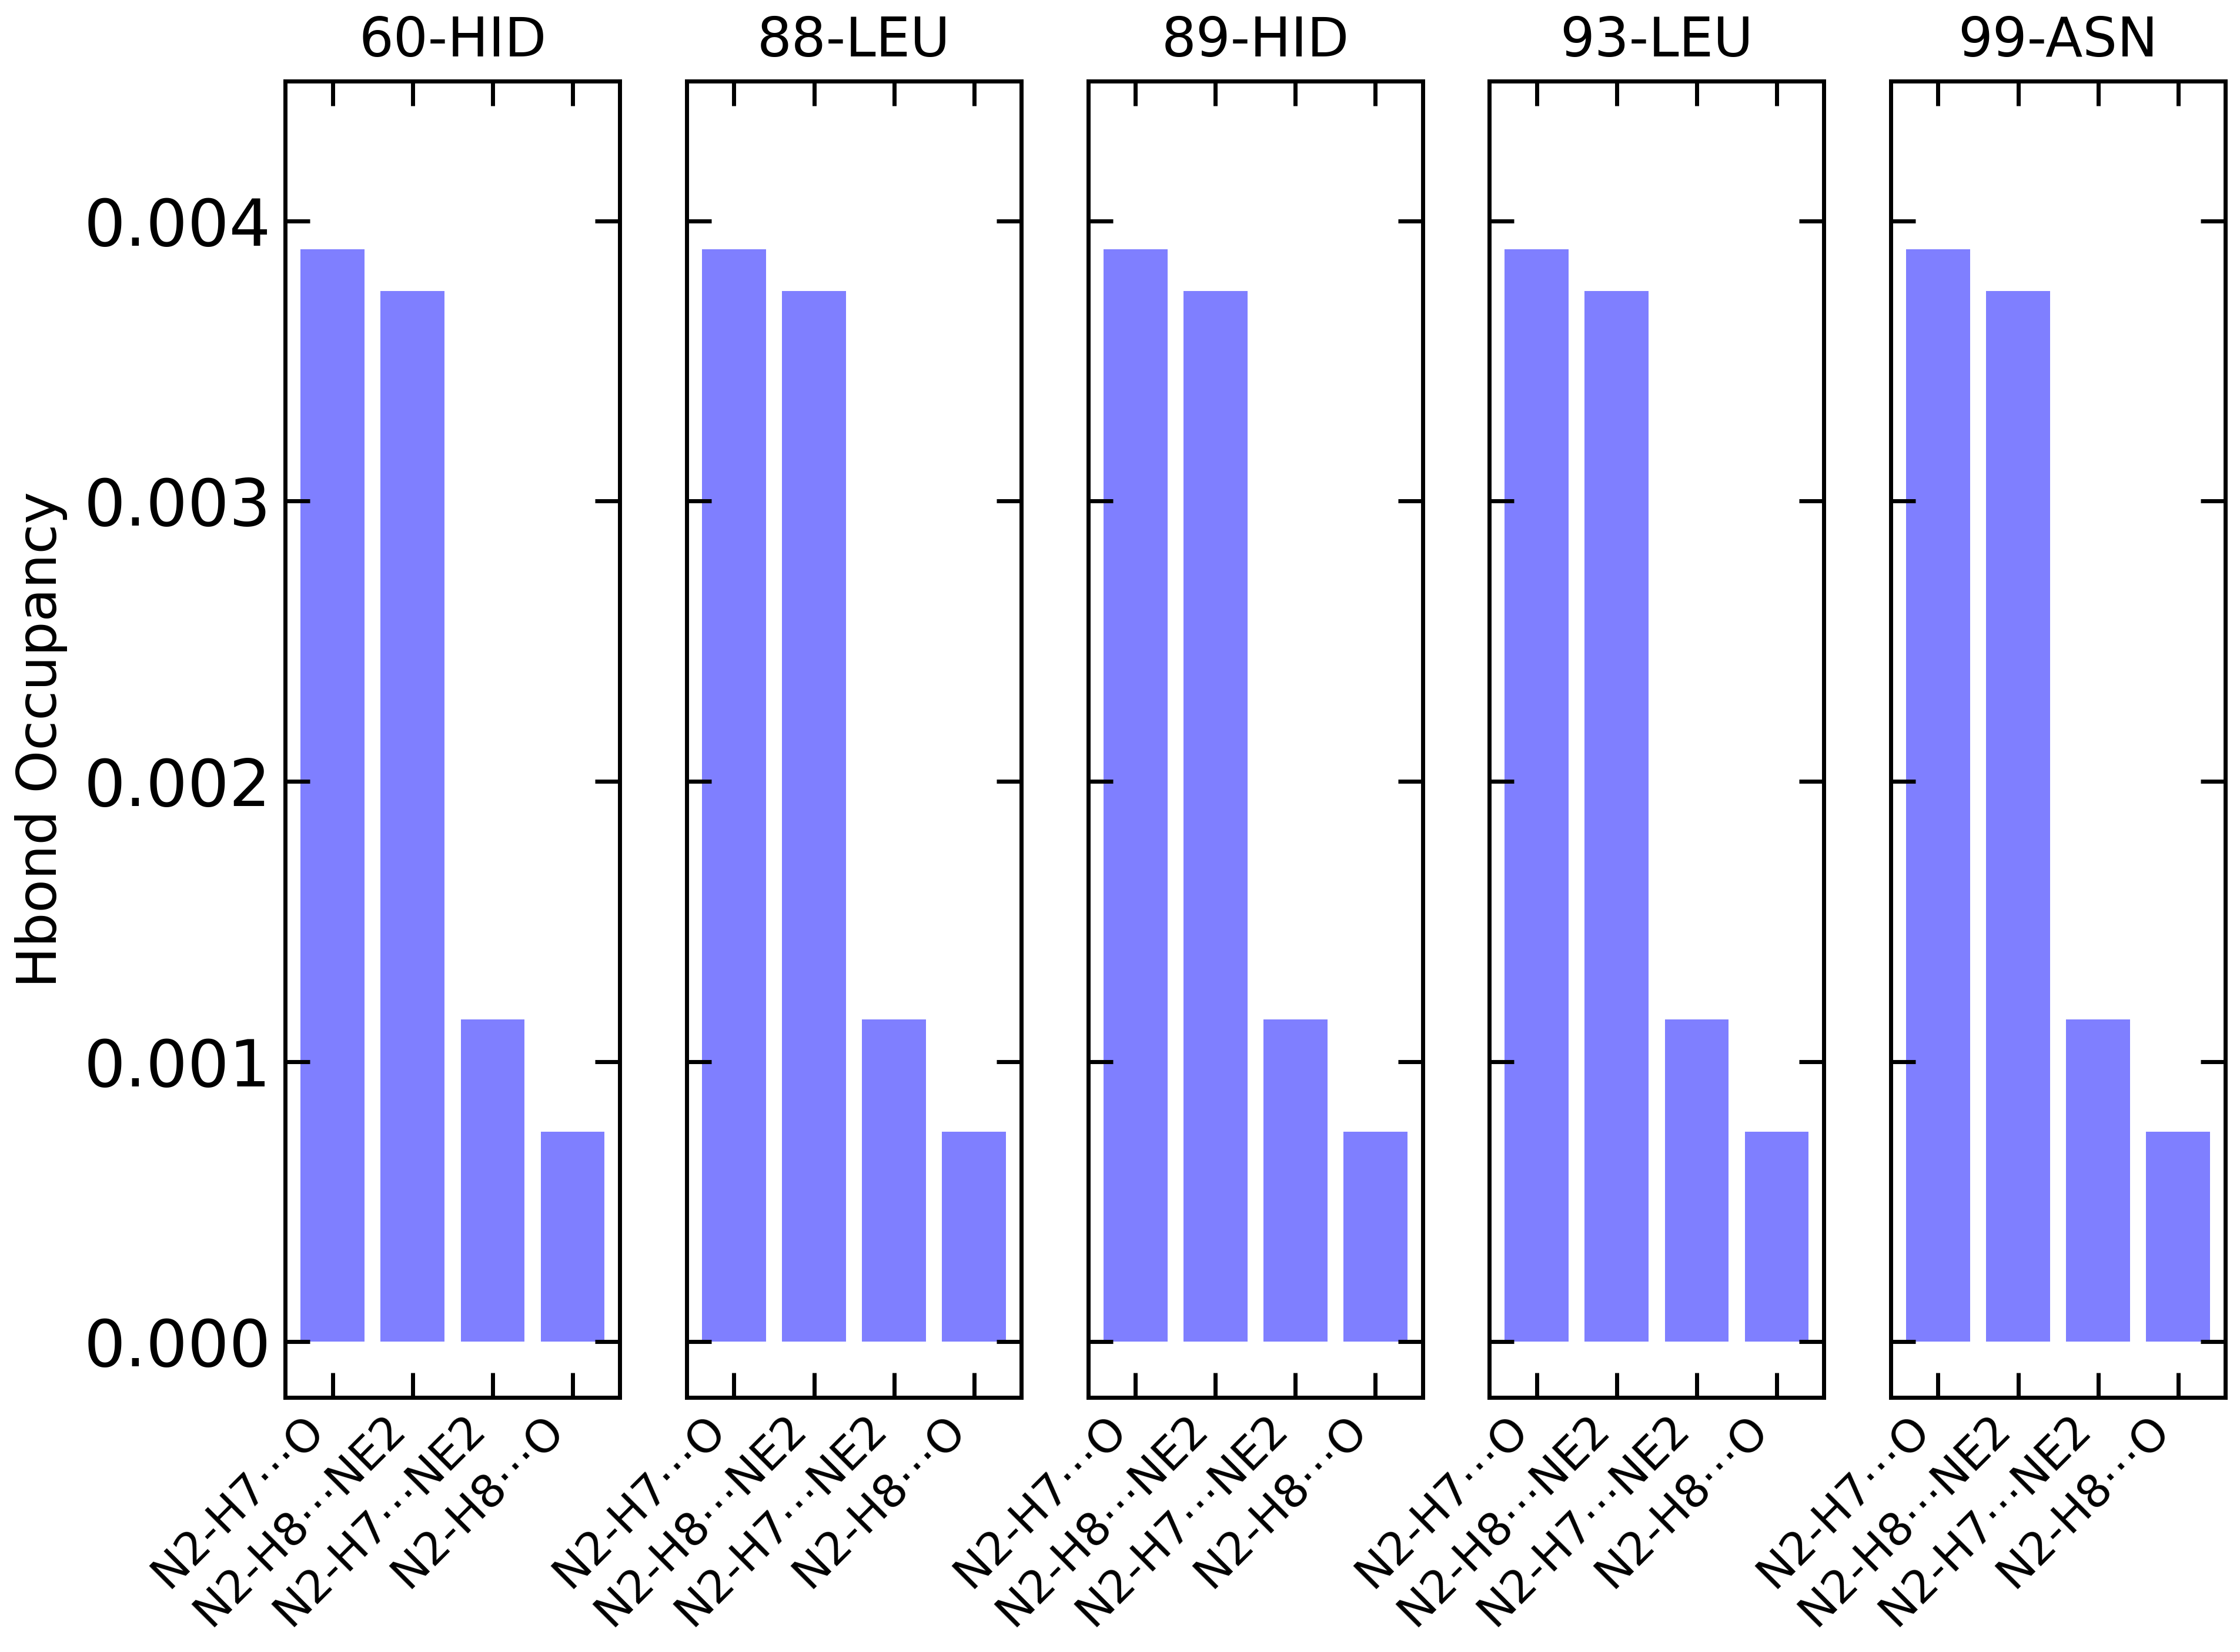

In [147]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import matplotlib.pyplot as plt
npanels = len(resnums)
plt.style.use(['science','notebook'])
frames = u.trajectory.n_frames
fig, axs = plt.subplots(1, npanels, sharey=True, tight_layout=True)   
for i, rn in enumerate(resnums):
        data_dict = {}
        counts = hbonds_top5[i].count_by_ids()
        for donor, hydrogen, acceptor, count in counts[:10]:
                d, h, a = u.atoms[donor], u.atoms[hydrogen], u.atoms[acceptor]
                data_dict[fr"{d.name}-{h.name}$\cdots${a.name}"]=count/frames
        
        probs = [value for value in data_dict.values()]
        axs[i].bar(data_dict.keys(), probs, color='blue', alpha=0.5)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right', fontsize='x-small')

        #axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, fontsize='large', ha='right')
        axs[i].set_ylim(-0.0002, 0.0045)

axs[0].set_ylabel("Hbond Occupancy", fontsize='small')
axs[0].set_title("60-HID",fontsize='small');
axs[1].set_title("88-LEU",fontsize='small');
axs[2].set_title("89-HID",fontsize='small');
axs[3].set_title("93-LEU",fontsize='small');
axs[4].set_title("99-ASN",fontsize='small');

for ax in axs:
        ax.minorticks_off()
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig("hbonds-refined.svg", dpi=600)

## Hydrogen Bond lifetimes via correlation analysis

For each of the bond pairs selected from the gaggle above, we plot 

\begin{equation*}
C^{ij}_x(t)=\left\langle\frac{h_{i j}\left(t_0\right) h_{i j}\left(t_0+t\right)}{h_{i j}\left(t_0\right)^2}\right\rangle_{t_0}
\end{equation*}

where 

\begin{equation*}
h_{ij} = \begin{cases}
1 & \text{If hbond: } i \to j\\
0 & \text{otherwise }
\end{cases}
\end{equation*}

The subscript in $C_x$, $x$, can be either $C$ (continuous) or $I$ (intermittent). When $x=C$, a bond, once broken, is assumed to never form again even if conditions are optimal, whereas when $x=I$, bond formation is counted regardless of history. Thus, a low $C_C(t)$ and high $C_I(t)$ indicates the dominance of intermittent hydrogen bonds. The curves are fit to exponential decays to yield bond life times.

**Note:** In this simulation, all the hydrogen bonds seem to be intermittent, as the bond probabilities are very low.

### List most frequent bonds

Let’s first find all hydrogen bonds from each of the $5$ chosen residues.

In [156]:
from tqdm.notebook import tqdm
import pandas as pd

hbonds_top5_each = []

for hb in tqdm(hbonds_top5):
    counts = hb.count_by_ids()
    for each in counts:
        hbonds_top5_each.append(each)
    lines = []
    for donor, hydrogen, acceptor, count in counts:
        d, h, a = u.atoms[donor], u.atoms[hydrogen], u.atoms[acceptor]
        lines.append(f"{d.name}<-->{h.name}<-->{a.resid}-{a.resname} {a.name} count={count}")

    df = pd.DataFrame(sorted(lines), columns=['Hydrogen Bond'])
    print(df)

hbonds_top5_each

  0%|          | 0/5 [00:00<?, ?it/s]

                       Hydrogen Bond
0       N2<-->H7<-->43-TYR O count=1
1    N2<-->H7<-->60-HID NE2 count=23
2     N2<-->H7<-->88-LEU O count=215
3   N2<-->H7<-->89-HID NE2 count=141
4       N2<-->H7<-->91-PHE O count=1
5      N2<-->H7<-->93-LEU O count=89
6       N2<-->H7<-->95-VAL O count=1
7      N2<-->H7<-->99-ASN O count=78
8     N2<-->H7<-->99-ASN OD1 count=1
9       N2<-->H8<-->43-TYR O count=9
10   N2<-->H8<-->60-HID NE2 count=75
11      N2<-->H8<-->63-THR O count=1
12      N2<-->H8<-->64-ILE O count=1
13     N2<-->H8<-->88-LEU O count=15
14  N2<-->H8<-->89-HID NE2 count=207
15     N2<-->H8<-->93-LEU O count=32
16      N2<-->H8<-->95-VAL O count=1
17     N2<-->H8<-->99-ASN O count=57
18    N2<-->H8<-->99-ASN OD1 count=2
                       Hydrogen Bond
0       N2<-->H7<-->43-TYR O count=1
1    N2<-->H7<-->60-HID NE2 count=23
2     N2<-->H7<-->88-LEU O count=215
3   N2<-->H7<-->89-HID NE2 count=141
4       N2<-->H7<-->91-PHE O count=1
5      N2<-->H7<-->93-LEU O count=89
6

[array([2233, 2234, 1319,  215]),
 array([2233, 2235, 1332,  207]),
 array([2233, 2234, 1332,  141]),
 array([2233, 2234, 1407,   89]),
 array([2233, 2234, 1497,   78]),
 array([2233, 2235,  924,   75]),
 array([2233, 2235, 1497,   57]),
 array([2233, 2235, 1407,   32]),
 array([2233, 2234,  924,   23]),
 array([2233, 2235, 1319,   15]),
 array([2233, 2235,  674,    9]),
 array([2233, 2235, 1492,    2]),
 array([2233, 2234, 1492,    1]),
 array([2233, 2234, 1447,    1]),
 array([2233, 2234, 1366,    1]),
 array([2233, 2235,  971,    1]),
 array([2233, 2235,  990,    1]),
 array([2233, 2235, 1447,    1]),
 array([2233, 2234,  674,    1]),
 array([2233, 2234, 1319,  215]),
 array([2233, 2235, 1332,  207]),
 array([2233, 2234, 1332,  141]),
 array([2233, 2234, 1407,   89]),
 array([2233, 2234, 1497,   78]),
 array([2233, 2235,  924,   75]),
 array([2233, 2235, 1497,   57]),
 array([2233, 2235, 1407,   32]),
 array([2233, 2234,  924,   23]),
 array([2233, 2235, 1319,   15]),
 array([2233, 

In [160]:
hbonds_top12 = np.array(hbonds_top5_each)
hbonds_top12 = np.unique(hbonds_top5_each, axis=0)
sorted_hbonds_top12 = hbonds_top12[hbonds_top12[:, -1].argsort()][::-1]
sorted_hbonds_top12

array([[2233, 2234, 1319,  215],
       [2233, 2235, 1332,  207],
       [2233, 2234, 1332,  141],
       [2233, 2234, 1407,   89],
       [2233, 2234, 1497,   78],
       [2233, 2235,  924,   75],
       [2233, 2235, 1497,   57],
       [2233, 2235, 1407,   32],
       [2233, 2234,  924,   23],
       [2233, 2235, 1319,   15],
       [2233, 2235,  674,    9],
       [2233, 2235, 1492,    2],
       [2233, 2234, 1492,    1],
       [2233, 2234, 1447,    1],
       [2233, 2234, 1366,    1],
       [2233, 2235,  971,    1],
       [2233, 2235,  990,    1],
       [2233, 2235, 1447,    1],
       [2233, 2234,  674,    1]])

Count only the first six bonds as there are very few instances of the rest.

In [162]:
sorted_hbonds_top6 = sorted_hbonds_top12[:6]
sorted_hbonds_top6

array([[2233, 2234, 1319,  215],
       [2233, 2235, 1332,  207],
       [2233, 2234, 1332,  141],
       [2233, 2234, 1407,   89],
       [2233, 2234, 1497,   78],
       [2233, 2235,  924,   75]])

Now we’ll calculate the lifetime of these hydrogen bonds. To do this, the simplest way is to run `HydrogenBondAnalysis` for each hydrogen bond then use the `lifetime` method. It is very efficient to find hydrogen bonds between two specific atoms, especially with `update_selections=False`.

In [163]:
# Run hbonds analysis serially (trajs are locked during each read, disallowing multiprocess reads) and store the results
hbond_results = []
for hbond in tqdm(sorted_hbonds_top6):
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds = HBA(
        universe=u,
        donors_sel=f"index {d_ix}",
        hydrogens_sel=f"index {h_ix}",
        acceptors_sel=f"index {a_ix}",
        update_selections=True
    )
    tmp_hbonds.run(verbose=True)
    hbond_results.append(tmp_hbonds)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2233, and Acceptor, index 1319.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2233, and Acceptor, index 1319.
  warnings.warn(


  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2233, and Acceptor, index 1332.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2233, and Acceptor, index 1332.
  warnings.warn(


  0%|          | 0/20001 [00:00<?, ?it/s]

  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2233, and Acceptor, index 1407.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2233, and Acceptor, index 1407.
  warnings.warn(


  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2233, and Acceptor, index 1497.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2233, and Acceptor, index 1497.
  warnings.warn(


  0%|          | 0/20001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2233, and Acceptor, index 924.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2233, and Acceptor, index 924.
  warnings.warn(


In [164]:
import multiprocessing
tau_max = 200
intermittency = 20
hbond_lifetimes = []
labels = [] # for plotting
def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
        intermittency=intermittency
    )
    return np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
pool = multiprocessing.Pool(6)
hbond_lifetimes = pool.map(calculate_lifetime, hbond_results)
pool.close()
pool.join()

hbond_lifetimes = np.array(hbond_lifetimes)

for d,h,a,c in sorted_hbonds_top6:
    donor, hydrogen, acceptor = u.atoms[d], u.atoms[h], u.atoms[a]
    labels.append(fr"{donor.name}---{hydrogen.name}$\cdots${acceptor.name} ({acceptor.resid}-{acceptor.resname})")


Finally, we can estimate the lifetime by fitting to exponential function (see references below)

\begin{equation*}
C_I(t) = A_1 e^{-t/\tau_1} + A_2 e^{-t/\tau_2} + \left(1-A_1 - A_2\right) e^{-t/\tau_3}
\end{equation*}

Here, the last term is said to contribute to the intermittent nature of the hydrogen bonds. The bond lifetime is given by the numerical integration

\begin{equation*}
\tau_I = \int^\infty_0 C_I(t) \mathrm{d}t.
\end{equation*}

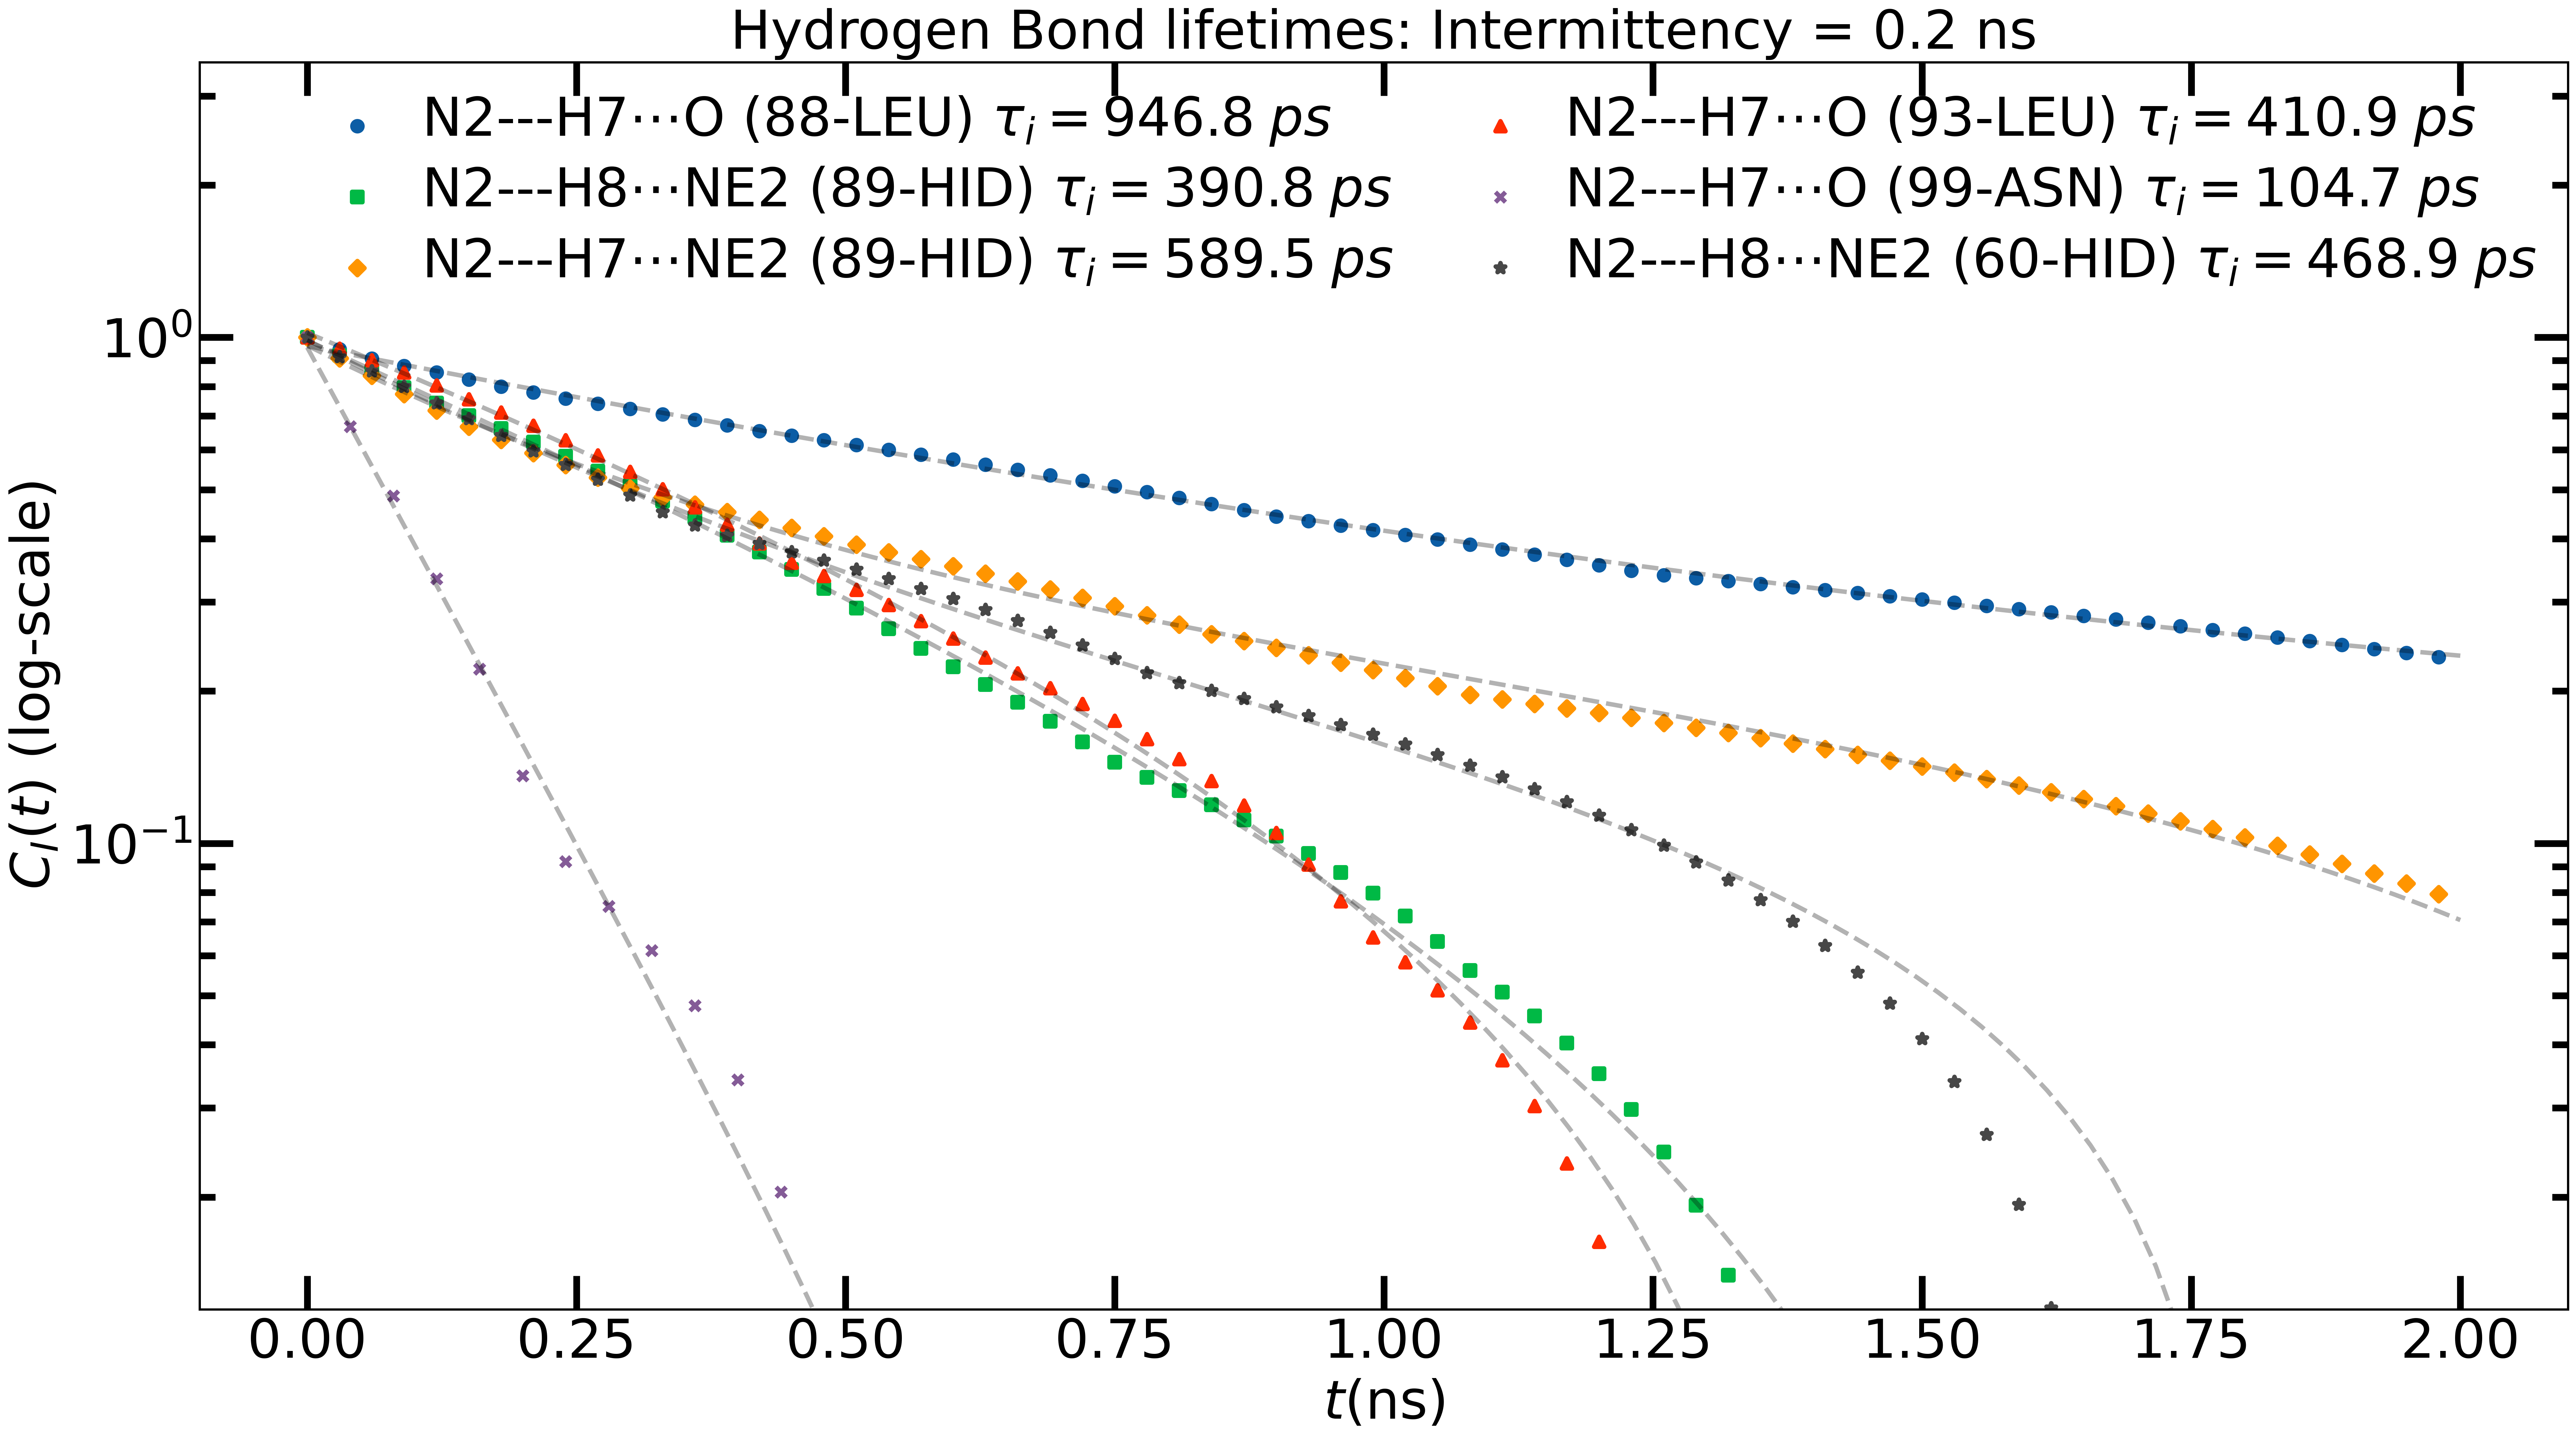

In [182]:
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt

def hbond_corr(x, A1, tau1, A2, tau2, A3, tau3):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2) + A3 * np.exp(-x/tau3)

intermittency_time = intermittency * u.trajectory.dt/1000
ax = plt.gca()
fig = plt.gcf()
#fig.set_size_inches(3*my_width, 3*my_width/golden)
ax.set_title(f"Hydrogen Bond lifetimes: Intermittency = {intermittency_time} ns")


# Plot the lifetimes
symbols = ['o', 's', 'D', '^', 'x', '*', 'v', 'p', 'h']  # List of symbols to cycle through

# Plot the lifetimes
for i, hbl in enumerate(hbond_lifetimes):
    taus, hbl = hbl[:, 0], hbl[:, 1]
    times = taus * u.trajectory.dt/1000
    
    try:
        popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[0.5, 10, 0.5, 20, 0.1, 30], maxfev=5000)
        fit_times = np.linspace(times[0], times[-1], 100)
        fit_hbl = hbond_corr(fit_times, *popt)
        tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
        tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 
        stride = 4 if i == 4 else 3
        if tau_i_ps > 1:
            ax.plot(fit_times, fit_hbl, color='black', ls='--', lw=2, alpha=0.3)
            ax.scatter(times[::stride], hbl[::stride], label=labels[i] + fr' $\tau_i = {tau_i_ps}\; ps$', lw=2, s=20,marker=symbols[i])
    except RuntimeError as e:
        print(f"Could not fit {labels[i]}")
        print(f"Exception: {e}")
        ax.scatter(times[::stride], hbl[::stride], label=labels[i], lw=2, s=20,marker=symbols[i])
        continue
    

ax.set_xlabel(r"$t \rm (ns)$")
ax.set_ylabel(r"$C_I(t)$ (log-scale)")
ax.set_yscale("log")
ax.set_ylim(1.2e-2, 3.5)

leg = ax.legend(ncol=2, loc="upper right")
ax.legend(ncol=2, loc="upper right")
fig.set_size_inches(16, 9)
fig.tight_layout()
# Increase font sizes of axis title, axis labels, and tick labels by 50%
elements = [ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()
for element in elements:
    element.set_fontsize(element.get_fontsize() * 1.5)
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.tick_params(axis='both', which='major', length=15, width=3)
ax.tick_params(axis='y', which='minor', length=7, width=3)
# Increase font sizes in the legend by 50%
leg = ax.get_legend()
frame = leg.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(1.5)
frame.set_alpha(0.6)
if leg is not None:
    for text in leg.get_texts():
        text.set_fontsize(text.get_fontsize() * 1.5)
plt.savefig("hbond_lifetimes.svg", dpi=600)
plt.show()

### References
1. Gowers RJ, Carbone P. A multiscale approach to model hydrogen bonding: The case of polyamide. The Journal of Chemical Physics. 2015;142(22):224907. [doi:10.1063/1.4922445](http://dx.doi.org/10.1063/1.4922445).
2. [MDAnalysis Guide (deprecated)](https://docs.mdanalysis.org/1.1.0/documentation_pages/analysis/hbond_autocorrel.html)

Is it really worthwhile to plot distances and angles with time if the bond probabilities are so low?

### Pretty Pics

Dump out PDBs and view pymol, since nglview seems to be crap. See below.

Also, do 2D representations in [LigPlot+](https://www.ebi.ac.uk/thornton-srv/software/LigPlus/).

Detect hydrogen bonds and write them into the PDB file as per instructions in LigPlot+ manual.

Select the most common residue ids that acted as acceptors.

Take the top-5 hbonds detected from the bar charts above, and enter each bond information into a list of dictionaries with first key being frameid and second being the bond string as specified by the ligplot+ manual. See 'Adding missing H-bonds' in [ligplot+ manual](https://www.ebi.ac.uk/thornton-srv/software/LigPlus/manual2/manual.html)

In [ ]:
%%script true
hbonds_top5_list = []
donor_chain = 'X'
acceptor_chain = 'A'
for hbonds in hbonds_top5:
    hbond = hbonds.results.hbonds[0]
    frame_idx, donor_index, hydrogen_index, acceptor_index, DA_distance, DHA_angle = hbond
    frame_idx, donor_index, hydrogen_index, acceptor_index, DA_distance, DHA_angle = \
        int(frame_idx), int(donor_index), int(hydrogen_index), int(acceptor_index), DA_distance, DHA_angle
    donor = u.atoms[donor_index]
    hydrogen = u.atoms[hydrogen_index]
    acceptor = u.atoms[acceptor_index]
    space = ' '
    donor_string = f'{donor.resname}' + space + donor_chain + space + str(donor.resid).rjust(4) + 3*space + donor.name.ljust(3)
    acceptor_string = f'{acceptor.resname}' + space + acceptor_chain + space + str(acceptor.resid).rjust(4) + 3*space + acceptor.name.ljust(3)

    bond_entry = 'HHB' + 3*space + donor_string + 5 * space + acceptor_string +    4 * space + f'{DA_distance:.2f}'
    hbonds_top5_list.append([frame_idx, bond_entry])
    
hbonds_top5_list

### Write each frame data to PDB and draw the hbonds in
Each PDB can be seen in 3D using `pymol` or 2D using `ligplot+`. The hbonds are written into the PDBs in case ligplot+ misses them. 

In [ ]:
%%script true

import os
from tqdm import tqdm

complex_prod = u.select_atoms('protein or resname PHZ')
out_dir = 'zeb_hb_phz_complex_sim/sys_prod/pdb_files'
os.makedirs(out_dir, exist_ok=True)

for hbond in tqdm(hbonds_top5_list):
    frame_idx, bond_entry = hbond

    for ts in u.trajectory:
        if ts.frame == frame_idx:
            pdb_filename = f'complex_time_{int(ts.time)}_ps.pdb'
            pdb_filename = os.path.join(out_dir, pdb_filename)
            complex_prod.write(pdb_filename)
            with open(pdb_filename, 'r') as file:
                lines = file.readlines()

            lines.insert(2, bond_entry + '\n')

            with open(pdb_filename, 'w') as file:
                file.writelines(lines)
            break

Finally, save the first frame (initial condition) into a PDB as well.

In [ ]:
%%script true

import os
from tqdm import tqdm

complex_prod = u.select_atoms('protein or resname PHZ')
out_dir = 'zeb_hb_phz_complex_sim/sys_prod/pdb_files'
os.makedirs(out_dir, exist_ok=True)

for ts in u.trajectory:
    if ts.frame == 0:
        pdb_filename = f'complex_init.pdb'
        pdb_filename = os.path.join(out_dir, pdb_filename)
        complex_prod.write(pdb_filename)
        break

## Notes on Hydrogen bonds and hydrophobic interactions

If phenylhydrazine is near a leucine (LEU) residue that is adjacent to an alanine (ALA) residue, the interaction would primarily involve hydrophobic interactions rather than hydrogen bonding. Both leucine and alanine are hydrophobic amino acids, meaning they tend to avoid water and prefer to interact with other nonpolar molecules or residues.

### Hydrophobic Interactions
- **Leucine (LEU)**: Has a larger, more complex hydrophobic side chain.
- **Alanine (ALA)**: Has a smaller, simpler hydrophobic side chain.

### Interaction with Phenylhydrazine
Phenylhydrazine itself has a hydrophobic phenyl ring, which can interact favorably with the hydrophobic side chains of leucine and alanine. These interactions help stabilize the binding of phenylhydrazine to the protein through van der Waals forces and hydrophobic effects.

### Hydrogen Bonding
Since neither leucine nor alanine has polar side chains, they cannot directly participate in hydrogen bonding with phenylhydrazine. However, if there are nearby residues with polar or charged side chains, those could potentially form hydrogen bonds with phenylhydrazine.

### Example Scenario
If phenylhydrazine is positioned near a leucine and alanine residue, it might be stabilized by the hydrophobic environment created by these residues. This could bring phenylhydrazine into proximity with other residues capable of hydrogen bonding, such as serine or threonine, if they are present nearby.

### Source: Conversation with Copilot, 30/09/2024
(1) Amino acid–base interactions: a three-dimensional analysis of protein .... https://academic.oup.com/nar/article/29/13/2860/1083188.

(2) Understanding the Specific Implications of Amino Acids in the Antibody .... https://link.springer.com/article/10.1007/s10930-024-10201-4.

(3) 3D interaction homology: The hydrophobic residues alanine, isoleucine .... https://www.frontiersin.org/journals/molecular-biosciences/articles/10.3389/fmolb.2023.1116868/full.

(4) undefined. https://doi.org/10.1093/nar/29.13.2860.

(5) The 20 Amino Acids and Their Role in Protein Structures. https://proteinstructures.com/sequence/amino-acids/.

(6) Alanine - benefits, side effects, food sources, dosage. Alanine .... https://aminoacidsguide.com/Ala.html.

(7) Dietary l-leucine and l-alanine supplementation have similar acute .... https://link.springer.com/article/10.1007/s00726-012-1363-2.

## PHZ and GLY
Yes, hydrogen bonds can form between a phenylhydrazine ligand and the glycine (GLY) residue in a protein. Glycine, being a small and flexible amino acid, often participates in hydrogen bonding through its backbone amide group (NH) and carbonyl group (C=O) ³. 

Phenylhydrazine has functional groups that can act as hydrogen bond donors or acceptors, such as the NH and NH2 groups. These groups can form hydrogen bonds with the carbonyl oxygen or the amide hydrogen of the glycine residue in the protein ¹².


Here is a table summarizing the possible hydrogen bonds between phenylhydrazine and a glycine residue, including the donor and acceptor groups:


| **Phenylhydrazine Group** | **Glycine Group**       | **Donor** | **Acceptor** |
|---------------------------|-------------------------|-----------|--------------|
| NH (amine)                | C=O (carbonyl)          | NH        | C=O          |
| NH2 (amine)               | C=O (carbonyl)          | NH2       | C=O          |
| NH (amine)                | NH (amide)              | NH        | NH           |
| NH2 (amine)               | NH (amide)              | NH2       | NH           |



### Source: Conversation with Copilot, 30/09/2024

(1) The 20 Amino Acids and Their Role in Protein Structures. https://proteinstructures.com/sequence/amino-acids/.

(2) Strong and Weak Hydrogen Bonds in Protein–Ligand Recognition. https://link.springer.com/article/10.1007/s41745-019-00141-9.

(3) Exploring the Composition of Protein-Ligand Binding Sites on a Large .... https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003321.

(4) Secondary Structure: α-Helices - Chemistry LibreTexts. https://chem.libretexts.org/Bookshelves/Biological_Chemistry/Supplemental_Modules_%28Biological_Chemistry%29/Proteins/Protein_Structure/Secondary_Structure%3A_-Helices.

(5) undefined. https://doi.org/10.1371/journal.pcbi.1003321.

## However

This reference [Magnusson et. al. J Biol Chem. 2004](https://doi.org/10.1074/jbc.m311890200) says that Leucine CAN form h-bonds (leucine and phenylalanine), but here leucine is in the ligand (I think).

Copilot suggests the following bond table

| **Donor Group**          | **Acceptor Group**       | **Hydrogen Bond**       |
|--------------------------|--------------------------|-------------------------|
| Phenylhydrazine - NH2    | Leucine - CO (carbonyl)  | NH2 (phenylhydrazine) - CO (leucine) |
| Phenylhydrazine - NH     | Leucine - CO (carbonyl)  | NH (phenylhydrazine) - CO (leucine)  |
| Leucine - NH (amide)     | Phenylhydrazine - NH2    | NH (leucine) - NH2 (phenylhydrazine) |
| Leucine - NH (amide)     | Phenylhydrazine - NH     | NH (leucine) - NH (phenylhydrazine)  |

### Additional Refs supporting leucine bonds


1. Caballero D, Smith WW, O’Hern CS, Regan L. Equilibrium transitions between side-chain conformations in leucine and isoleucine: Leucine and Isoleucine Transitions. Proteins. 2015;83(8):1488-1499. [doi:10.1002/prot.24837](https://onlinelibrary.wiley.com/doi/10.1002/prot.24837)

## Principal Component Analysis

### PCA via GROMACS tools

First, create an index for backbone, ligand.

`gmx make_ndx -f prod_zeb_hb_phz_complex.gro -o pca_index.ndx ` Choose backbone OR PHZ

Then, we need to dump the first frame of MD simulation as pdb file (unless that has already been done).

`gmx trjconv -s md.tpr -f prod_zeb_hb_phz_complex_compact_compact.xtc -o start.pdb -dump 0`

Selections should be the index just created.

Then, generating the eigenvectors

```bash
gmx covar -s start.pdb -f prod_zeb_hb_phz_complex_compact_compact.xtc -o prod_zeb_hb_phz_complex_eigenvalues.xvg -v prod_zeb_hb_phz_complex_eigenvectors.trr -xpma prod_zeb_hb_phz_complex_covapic.xpm -n pca_index.ndx
```
Selections should be the index just created.

Followed by `gmx anaeig` to generate pc1 and pc2 files

```bash
gmx anaeig -f prod_zeb_hb_phz_complex_compact_compact.xtc -s start.pdb -v prod_zeb_hb_phz_complex_eigenvectors.trr -last 1 -proj prod_zeb_hb_phz_complex_pc1.xvg -n pca_index.ndx

gmx anaeig -f prod_zeb_hb_phz_complex_compact_compact.xtc -s start.pdb -v prod_zeb_hb_phz_complex_eigenvectors.trr -first 2 -last 2 -proj prod_zeb_hb_phz_complex_pc2.xvg -n pca_index.ndx
```

Use these two xvg files (pc1.xvg and pc2.xvg) to generate the following plots.

In [ ]:
%%script true

import numpy as np

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for RMSD and radius of gyration XVG files
pc1_file = 'zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_pc1.xvg'
pc2_file = 'zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_pc2.xvg'

# Read data from XVG files with skip headers
t1, pc1_data = read_xvg(pc1_file, skip_header=24)  # Adjust skip_header based on your file format
t2, pc2_data = read_xvg(pc2_file, skip_header=24)  # Adjust skip_header based on your file format

In [ ]:
%%script true

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
plt.plot(t1/1000, pc1_data, label='PC1')
plt.plot(t2/1000, pc2_data, label='PC2')
plt.xlabel('Time (ns)')
plt.ylabel('Principal Component')
plt.legend()

For PCA with respect to energy, first

`paste prod_zeb_hb_phz_complex_pc1.xvg prod_zeb_hb_phz_complex_pc1.xvg | awk '{print $1, $2, $4}' > prod_zeb_hb_phz_complex_pc1pc2.xvg`

Then, use this PC1PC2.xvg file to generate an xpm file

`gmx sham -f prod_zeb_hb_phz_complex_pc1pc2.xvg -ls prod_zeb_hb_phz_complex_FES.xpm`

Then use the following `xpm2txt.py` script to convert the .xpm file into .dat file:


In [ ]:
%%script true

#!/usr/bin/env python3

import sys

"""
Utility tool to convert xpm files generated by GROMACS to a 3-column text file.
"""

USAGE = "USAGE: xpm2txt.py -f <input xpm file> -o <output txt file> [-s]\n"
USAGE += "Options:\n"
USAGE += "\t-s\t(int)\tSorts the output by a given column"
USAGE += "\n"  # always keep this line

# Parse arguments
read_input, read_output, sort = False, False, False
xpm_file, out_file, column_sort = None, None, None
for arg in sys.argv[1:]:
    if read_input:
        read_input = False
        xpm_file = arg
    elif read_output:
        read_output = False
        out_file = arg
    elif sort:
        sort = False
        column_sort = int(arg)
    if arg.startswith("-"):
        if arg == "-f":
            read_input = True
            continue
        elif arg == "-o":
            read_output = True
            continue
        elif arg == "-s":
            sort = True
        else:
            print(USAGE)
            sys.stderr.write('ERROR: Option not recognized: %s\n' % arg)
            sys.exit(1)

if not xpm_file:
    print(USAGE)
    sys.stderr.write('ERROR: You forgot to provide an input file.\n')
    sys.exit(1)
if not out_file:
    out_file = "out.txt"

# Parse XPM file
with open(xpm_file) as xpm_handle:
    xpm_data = []
    x_axis, y_axis = [], []
    letter_to_value = {}
    for line in xpm_handle:
        if line.startswith("/* x-axis"):
            x_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith("/* y-axis"):
            y_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith('"') and x_axis and y_axis:  # Read data
            xpm_data.insert(0, line.strip().strip(',')[1:-1])

        if line.startswith('"') and len(line.split()) > 4:
            letter = line.split()[0][1:]
            value = float(line.split()[-2][1:-1])
            letter_to_value[letter] = value

# Match x/y/data
txt_values = []
for y_index, data_value in enumerate(xpm_data):
    y_value = y_axis[y_index]
    for x_index, x_value in enumerate(x_axis):
        txt_values.append([x_value, y_value, letter_to_value[data_value[x_index]]])

# Apply sorting if requested
if column_sort:
    try:
        txt_values.sort(key=lambda x: x[column_sort - 1])
    except IndexError:
        print(USAGE)
        sys.stderr.write('ERROR: Column not found (%s)\n' % (column_sort))
        sys.exit(1)

# Print to file
with open(out_file, 'w') as out_handle:
    for x, y, z in txt_values:
        out_handle.write("%3.5f\t%3.5f\t%3.5f\n" % (x, y, z))

Use this above-mentioned script as

```bash
./xpm2txt.py -f prod_zeb_hb_phz_complex_FES.xpm -o prod_zeb_hb_phz_complex_FEL.dat
```

In [ ]:
%%script true

import matplotlib.pyplot as plt
import numpy as np

# Read input data from a file
input_file = 'zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_FEL.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC1 = data[:, 0]
PC2 = data[:, 1]
free_energy = data[:, 2]


# Function to read XVG file and extract data
def read_xvg(file_path):
    data = np.genfromtxt(file_path, skip_header=18)  # Adjust skip_header based on your XVG file format
    xpoints = data[:, 0]
    ypoints = data[:, 1]
    return xpoints, ypoints

# Replace these placeholders with your actual file paths
D1_path = 'zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_eigenvalues.xvg'

# Read data from XVG files
time_D1, D1_data = read_xvg(D1_path)


In [ ]:
%%script true

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scienceplots
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import matplotlib.pyplot as plt

plt.style.use(['science','notebook'])

#########################################################################################
# Adjust this to pinpoint the delta G cross-section at the PC1 values you want to analyze 
pc1_values = np.array([2.82329, 3.52922])

# Adjust this to set the initial guess for the minima search
trial_minima = [0, -15]
#########################################################################################

# Create a figure with 3 panels
fig = plt.figure(tight_layout=True, figsize=(40, 40))

# Upper left panel: Eigenvalue cumulative sum plot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(time_D1[0:50], D1_data[0:50], color='red')
ax1.set_xlim(1, )
ax1.set_ylim(0, )
ax1.set_xlabel('Eigenvector index')
ax1.set_ylabel(r'Variance $\left(nm^2\right)$')
ax1.set_title('PCA of ZebHb + PHZ Complex')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.tick_params(axis='both', which='major')

# Upper right panel: 3D plot of the free energy
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot_trisurf(PC1, PC2, free_energy/4.184, cmap='viridis', alpha=0.8)
ax2.zaxis.set_rotate_label(False)  # disable automatic rotation
ax2.set_xlabel(r'$PC_1\left(nm\right)$', labelpad=25)
ax2.xaxis.set_tick_params(pad=10)
ax2.set_ylabel(r'$PC_2\left(nm\right)$', labelpad=20)
ax2.yaxis.set_tick_params(pad=0)
ax2.set_title(r'Free Energy Landscape: $\Delta G\; \left(kcal \cdot mol^{-1}\right)$')
ax2.scatter(PC1, PC2, c=free_energy/4.184, cmap='viridis', s=50, alpha=0.5)
ax2.plot(pc1_data, pc2_data, 0, color='magenta', label='Trajectory')
ax2.view_init(elev=15, azim=-40)
ax2.legend()


fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax2.set_position([0.55, 0.55, 0.8, 0.8])  # [left, bottom, width, height]

# Make all mark sizes bigger
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', length=20)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)
    ax.title.set_size(25)
    ax.legend(frameon=True, fontsize=25)
    if hasattr(ax, 'zaxis'):
        ax.zaxis.label.set_size(25)
        ax.zaxis.set_tick_params(labelsize=25)

# Show the plot
plt.savefig('pca_fel.png', dpi=600)
plt.show()

The two principal components are largely correlated, and there is no global free energy minimum in which the trajectory would settle. Thus, nothing of importance is happening, and this simulation is a good **negative control**.

In [ ]:
# Dump the checkpoint_dict to a pickle file for later reload
with open("checkpoint_dict.pkl", "wb") as f:
    pickle.dump(checkpoint_dict, f)
print("Checkpoint dictionary is saved to 'checkpoint_dict.pkl'")

In [ ]:
%%script true
with open("checkpoint_dict.pkl", "rb") as f:
    checkpoint_dict = pickle.load(f)

for key, value in checkpoint_dict.items():
    globals()[key] = value